In [ ]:
import pandas as pd
import numpy as np
import re

import urllib.parse
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

tqdm.pandas()


In [5]:
URL_REGEX = re.compile(r'https?://\S+|www\.\S+')
IP_REGEX = re.compile(r'\b\d{1,3}(\.\d{1,3}){3}\b')

SUSPICIOUS_TOKENS = [
    "login", "verify", "update", "secure", "account",
    "bank", "confirm", "password"
]

def extract_url_features(text):
    if not isinstance(text, str):
        return (0, 0, 0, 0)

    urls = URL_REGEX.findall(text)
    num_urls = len(urls)

    if num_urls == 0:
        return (0, 0, 0, 0)

    total_len = 0
    has_ip = 0
    suspicious = 0

    for url in urls:
        total_len += len(url)

        if IP_REGEX.search(url):
            has_ip = 1

        # 🔒 SAFE URL PARSING
        try:
            parsed = urllib.parse.urlparse(url)
            url_text = (parsed.netloc + parsed.path + parsed.query).lower()
        except ValueError:
            # Skip malformed URLs instead of crashing
            continue

        for token in SUSPICIOUS_TOKENS:
            if token in url_text:
                suspicious += 1

    avg_len = total_len / num_urls if num_urls else 0

    return (num_urls, avg_len, has_ip, suspicious)


In [6]:
DATASET_PATH = "data/phishing_email.csv"

df = pd.read_csv(DATASET_PATH)
print("Dataset shape:", df.shape)

possible_text_cols = ["Email Text", "Content", "Body", "Message"]
possible_label_cols = ["Email Type", "Label", "Target", "Category"]

TEXT_COL = next(c for c in possible_text_cols if c in df.columns)
LABEL_COL = next(c for c in possible_label_cols if c in df.columns)

print("Text column:", TEXT_COL)
print("Label column:", LABEL_COL)


Dataset shape: (18650, 3)
Text column: Email Text
Label column: Email Type


In [7]:
print("Extracting URL features...")
url_features = df[TEXT_COL].progress_apply(extract_url_features)

num_urls, avg_len, has_ip, suspicious = zip(*url_features)

numeric_df = pd.DataFrame({
    "num_urls": num_urls,
    "avg_url_len": avg_len,
    "any_url_has_ip": has_ip,
    "suspicious_url_tokens": suspicious
})

texts = df[TEXT_COL].fillna("").astype(str).tolist()
labels = df[LABEL_COL].fillna("Unknown")

print("Total samples:", len(texts))


Extracting URL features...


100%|██████████| 18650/18650 [00:00<00:00, 22211.98it/s]


Total samples: 18650


In [8]:
le = LabelEncoder()
y = le.fit_transform(labels)

print("Classes:", le.classes_)
print(pd.Series(y).value_counts())


Classes: ['Phishing Email' 'Safe Email']
1    11322
0     7328
Name: count, dtype: int64


In [9]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    stop_words="english"
)

X_text = tfidf.fit_transform(texts)
X_num = csr_matrix(numeric_df.values.astype(float))

X = hstack([X_text, X_num], format="csr")

print("TF-IDF shape:", X_text.shape)
print("Numeric feature shape:", X_num.shape)
print("Final feature shape:", X.shape)


TF-IDF shape: (18650, 20000)
Numeric feature shape: (18650, 4)
Final feature shape: (18650, 20004)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [11]:
xgb = XGBClassifier(
    n_estimators=350,
    max_depth=6,
    learning_rate=0.09,
    subsample=0.85,
    colsample_bytree=0.85,
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

print("Training XGBoost...")
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)

print("\nXGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, target_names=le.classes_))


Training XGBoost...

XGBoost Accuracy: 0.9616621983914209
                precision    recall  f1-score   support

Phishing Email       0.93      0.98      0.95      1466
    Safe Email       0.98      0.95      0.97      2264

      accuracy                           0.96      3730
     macro avg       0.96      0.96      0.96      3730
  weighted avg       0.96      0.96      0.96      3730



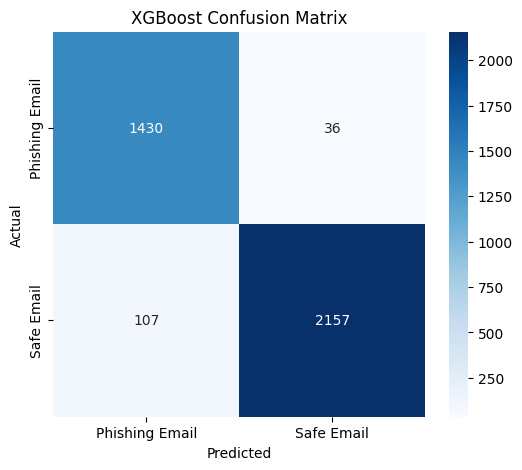

In [12]:
cm = confusion_matrix(y_test, xgb_preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for tr, val in skf.split(X, y):
    xgb.fit(X[tr], y[tr])
    preds = xgb.predict(X[val])
    cv_scores.append(accuracy_score(y[val], preds))

print("XGBoost CV Accuracy: %.4f ± %.4f" % (np.mean(cv_scores), np.std(cv_scores)))


XGBoost CV Accuracy: 0.9626 ± 0.0036


In [14]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print("\nLogistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds, target_names=le.classes_))



Logistic Regression Accuracy: 0.9753351206434316
                precision    recall  f1-score   support

Phishing Email       0.96      0.98      0.97      1466
    Safe Email       0.99      0.97      0.98      2264

      accuracy                           0.98      3730
     macro avg       0.97      0.98      0.97      3730
  weighted avg       0.98      0.98      0.98      3730



In [16]:
# ===============================
# 12. Baseline 2 — Naive Bayes (Text-Only, Correct)
# ===============================

# Re-split RAW TEXT (not feature matrices)
X_text_train_raw, X_text_test_raw, y_nb_train, y_nb_test = train_test_split(
    texts,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Separate TF-IDF for NB (text-only baseline)
tfidf_nb = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=2,
    stop_words="english"
)

X_text_train_nb = tfidf_nb.fit_transform(X_text_train_raw)
X_text_test_nb  = tfidf_nb.transform(X_text_test_raw)

nb = MultinomialNB()
nb.fit(X_text_train_nb, y_nb_train)

nb_preds = nb.predict(X_text_test_nb)

print("\nNaive Bayes (Text Only) Accuracy:",
      accuracy_score(y_nb_test, nb_preds))

print(classification_report(
    y_nb_test,
    nb_preds,
    target_names=le.classes_
))



Naive Bayes (Text Only) Accuracy: 0.9613941018766756
                precision    recall  f1-score   support

Phishing Email       0.98      0.92      0.95      1466
    Safe Email       0.95      0.99      0.97      2264

      accuracy                           0.96      3730
     macro avg       0.97      0.95      0.96      3730
  weighted avg       0.96      0.96      0.96      3730



In [17]:
joblib.dump(xgb, "email_xgb_model.joblib")
joblib.dump(tfidf, "email_tfidf.joblib")
joblib.dump(le, "email_label_encoder.joblib")

print("Models saved successfully.")


Models saved successfully.


In [18]:
def predict_email(text):
    url_feats = extract_url_features(text)
    X_num_new = csr_matrix(np.array(url_feats).reshape(1, -1))
    X_text_new = tfidf.transform([text])
    X_new = hstack([X_text_new, X_num_new], format="csr")

    pred = xgb.predict(X_new)[0]
    proba = xgb.predict_proba(X_new)[0][1]

    return le.inverse_transform([pred])[0], proba


In [19]:
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

print("LR ROC-AUC:", lr_auc)

LR ROC-AUC: 0.9974058638925178
